In [0]:
import os
import re
import hashlib
from pathlib import Path
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt

from sklearn import metrics 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LSTM, Masking
from keras.optimizers import Adam
from keras.utils import to_categorical, Sequence
from keras.callbacks import LearningRateScheduler

In [0]:
from google.colab import drive
drive.mount('/gdrive')

In [0]:
def plot_accuracy(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.legend(['Train acc', 'Valid acc'], loc='lower right')
  plt.show()

def plot_loss(history):
  color = 'tab:orange'
  fig, ax1 = plt.subplots()
  ax1.plot(history.history['loss'], color=color)

  ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
  color = 'tab:blue'
  ax2.plot(history.history['val_loss'], color=color)
  
  fig.tight_layout()
  plt.legend(['Train loss', 'Valid loss'], loc='upper right')
  plt.show()

In [0]:
def which_set(filename, validation_percentage, testing_percentage):
    """Determines which data partition the file should belong to.

    We want to keep files in the same training, validation, or testing sets even
    if new ones are added over time. This makes it less likely that testing
    samples will accidentally be reused in training when long runs are restarted
    for example. To keep this stability, a hash of the filename is taken and used
    to determine which set it should belong to. This determination only depends on
    the name and the set proportions, so it won't change as other files are added.

    It's also useful to associate particular files as related (for example words
    spoken by the same person), so anything after '_nohash_' in a filename is
    ignored for set determination. This ensures that 'bobby_nohash_0.wav' and
    'bobby_nohash_1.wav' are always in the same set, for example.

    Args:
    filename: File path of the data sample.
    validation_percentage: How much of the data set to use for validation.
    testing_percentage: How much of the data set to use for testing.

    Returns:
    String, one of 'train', 'validation', or 'test'.
    """
    validation_percentage *= 100
    testing_percentage *= 100
    MAX_NUM_WAVS_PER_CLASS = 2**27 - 1  # ~134M
    base_name = os.path.basename(filename)
    # We want to ignore anything after '_nohash_' in the file name when
    # deciding which set to put a wav in, so the data set creator has a way of
    # grouping wavs that are close variations of each other.
    hash_name = re.sub(r'_nohash_.*$', '', base_name)
    # This looks a bit magical, but we need to decide whether this file should
    # go into the training, testing, or validation sets, and we want to keep
    # existing files in the same set even if more files are subsequently
    # added.
    # To do that, we need a stable way of deciding based on just the file name
    # itself, so we do a hash of that and then use that to generate a
    # probability value that we use to assign it.
    hash_name_hashed = hashlib.sha1(hash_name.encode('utf-8')).hexdigest()
    percentage_hash = ((int(hash_name_hashed, 16) %
                      (MAX_NUM_WAVS_PER_CLASS + 1)) *
                     (100.0 / MAX_NUM_WAVS_PER_CLASS))
    
    if percentage_hash < validation_percentage:
        result = 'validation'
    elif percentage_hash < (testing_percentage + validation_percentage):
        result = 'test'
    else:
        result = 'train'
    return result

In [0]:
# function for extracting features from the entire dataset
def shuffle_in_unison(x, y, seed=None):
    assert len(x) == len(y)
    if seed is not None:
        np.random.seed(seed)
    p = np.random.permutation(len(x))
    return x[p], y[p]

def get_data(path: str, dataset: str, labels: list,
                 validation_size: float, test_size: float,
                 n_mfcc: int=13, hop_length: int=512, timeseries_length: int=64):
    if dataset not in ['train', 'test', 'validation']:
        raise RuntimeError("Select one of \'train\', \'test\', \'validation\'")

    x = []
    y = []
    if 'unknown' not in labels:
        labels.append('unknown')
    no_labels = len(labels)
    for root, dirs, files in os.walk(path):
        if len(files) > 0:
            label = root.split('\\')[-1]
            x += [Path(root) / file for file in files
                       if which_set(file, validation_size, test_size) == dataset]
            no = labels.index(label) if label in labels else labels.index('unknown')
            y += [no for file in files
                       if which_set(file, validation_size, test_size) == dataset]

    x = np.array(x)
    y = np.array(y)
    y = to_categorical(y)
    x, y = shuffle_in_unison(x, y, seed=1)

    #####
    # lets try to load all the data
    data = np.zeros((len(x), timeseries_length, n_mfcc+20))
    max_mfcc_length = 0

    print("Loading audio files...")
    for i, file in enumerate(x):
        print(f"\r{i}/{len(x)}", end='')
        file_path = x[i]
        audio, sr = librosa.load(file_path)
        mfcc = librosa.feature.mfcc(
            y=audio, sr=sr, hop_length=hop_length, n_mfcc=n_mfcc
        )
        spectral_center = librosa.feature.spectral_centroid(
            y=audio, sr=sr, hop_length=hop_length
        )
        chroma = librosa.feature.chroma_stft(y=audio, sr=sr, hop_length=hop_length)
        spectral_contrast = librosa.feature.spectral_contrast(
            y=audio, sr=sr, hop_length=hop_length
        )
        if len(mfcc) > max_mfcc_length:
            max_mfcc_length = len(mfcc)
        mfcc = mfcc.T[0:timeseries_length, :]
        data[i, 0:len(mfcc), 0:n_mfcc] = mfcc
        data[i, 0:len(mfcc), n_mfcc:n_mfcc+1] = spectral_center.T[0:timeseries_length, :]
        data[i, 0:len(mfcc), n_mfcc+1:n_mfcc+13] = chroma.T[0:timeseries_length, :]
        data[i, 0:len(mfcc), n_mfcc+13:n_mfcc+20] = spectral_contrast.T[0:timeseries_length, :]
    
    #data = data[:, 0:max_mfcc_length, :]
    print(f"\r{len(x)}/{len(x)}")
    return data, y, max_mfcc_length

In [0]:
# Extract features from audio files
validation_size = 0.1
test_size = 0.1
labels=['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown']

#train_x, train_y, train_max_mfcc_length = get_data(Path('train/audio'), 'train',
#                            labels, validation_size, test_size)
#validation_x, validation_y, val_max_mfcc_length = get_data(Path('train/audio'), 'validation',
#                                      labels, validation_size, test_size)
#test_x, test_y, test_max_mfcc_length = get_data(Path('train/audio'), 'test',
#                          labels, validation_size, test_size)


In [0]:
## These np arrays need a lot of time to create so we'll save them in case something goes wrong.
#np.save(Path('train/train_x_13mfcc'), train_x)
#np.save(Path('train/train_y_13mfcc'), train_y)
#np.save(Path('train/validation_x_13mfcc'), validation_x)
#np.save(Path('train/validation_y_13mfcc'), validation_y)
#np.save(Path('train/test_x_13mfcc'), test_x)
#np.save(Path('train/test_y_13mfcc'), test_y)

In [0]:
prefix = '/gdrive/My Drive/data/'

In [0]:
# In case something goes wrong restore the data
train_x = np.load(Path(prefix+'train_x_13mfcc.npy'))
train_y = np.load(Path(prefix+'train_y_13mfcc.npy'))
validation_x = np.load(Path(prefix+'validation_x_13mfcc.npy'))
validation_y = np.load(Path(prefix+'validation_y_13mfcc.npy'))
test_x = np.load(Path(prefix+'test_x_13mfcc.npy'))
test_y = np.load(Path(prefix+'test_y_13mfcc.npy'))

In [11]:
# 'unknown' class is extremely unbalanced
_, counts = np.unique(train_y, return_counts=True, axis=0)
class_weights = dict(zip(range(11), counts))
print(class_weights)

{0: 32550, 1: 1861, 2: 1885, 3: 1839, 4: 1864, 5: 1852, 6: 1839, 7: 1842, 8: 1843, 9: 1853, 10: 1860}


In [0]:
def lfScheduleF(epoch, lr):
  if epoch > 50:
      return 0.01
  if epoch > 25:
      return 0.05
  return 0.1

lrschedulerDropout = LearningRateScheduler(lfScheduleF, verbose=0)


In [0]:
def create_model():
    model = Sequential()
    model.add(LSTM(33, return_sequences=True, input_shape=(None, 33)))
    model.add(LSTM(128, return_sequences=False))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(len(labels), activation='softmax'))
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    print(model.summary())
    return model

In [70]:
model = create_model()
history = model.fit(train_x, 
                    train_y, 
                    batch_size=400, 
                    epochs=30, 
                    class_weight=class_weights,
                    validation_data=(validation_x, validation_y)
                    )

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_30 (LSTM)               (None, None, 33)          8844      
_________________________________________________________________
lstm_31 (LSTM)               (None, 128)               82944     
_________________________________________________________________
dense_35 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_36 (Dense)             (None, 11)                1419      
Total params: 109,719
Trainable params: 109,719
Non-trainable params: 0
_________________________________________________________________
None
Train on 51088 samples, validate on 6798 samples
Epoch 1/30
51088/51088 [==============================] - 42s 823us/step - loss: 4227.6351 - accuracy: 0.4699 - val_loss: 1.6872 - val_accuracy: 0.5213
Epoch 2/30
51088/51088 [===============

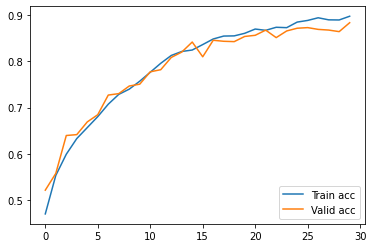

In [77]:
plot_accuracy(history)

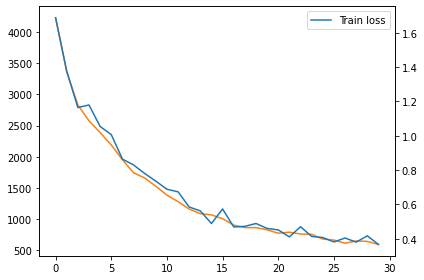

In [82]:
plot_loss(history)